In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import statsmodels.api as sm

In [2]:
dt = 1.0 / 300.0

In [3]:
import math
import os


def lpf(cutoff_freq: float, sample_freq: float, data: np.ndarray) -> np.ndarray:
    assert cutoff_freq > 0
    assert sample_freq > 0

    Q = 1 / math.sqrt(2)
    omega = 2 * math.pi * cutoff_freq / sample_freq
    alpha = math.sin(omega) / (2 * Q)
    a0 = 1 + alpha

    b0 = (1 - math.cos(omega)) / 2
    b1 = 1 - math.cos(omega)
    b2 = b0
    a1 = -2 * math.cos(omega)
    a2 = 1 - alpha

    b0 /= a0
    b1 /= a0
    b2 /= a0
    a1 /= a0
    a2 /= a0

    N, C = data.shape  # N is number of samples, C is number of channels
    filtered_data = np.zeros_like(data)
    # delay is [x_n-1, x_n-2, y_n-1, y_n-2]
    delay = np.zeros([4, C])
    for i in range(N):
        x_n = data[i]
        # assert that the shape of delay is (4, <shape of x_n>):
        assert delay.shape == (4, *x_n.shape)
        x_n1, x_n2, y_n1, y_n2 = delay
        y_n = b0 * x_n + b1 * x_n1 + b2 * x_n2 - a1 * y_n1 - a2 * y_n2
        delay = np.array([x_n, x_n1, y_n, y_n1])
        filtered_data[i] = delay[2]
    return filtered_data


def load_flight_data() -> tuple[np.ndarray, np.ndarray]:
    telemetry = os.path.join(os.path.abspath(""), "../telemetry.csv")
    df = pl.read_csv(telemetry)
    body_ang_rate = df.select(["body_ang_vel_x", "body_ang_vel_y", "body_ang_vel_z"]).to_numpy()
    motor_ang_rate = df.select(
        ["motor_ang_vel_1", "motor_ang_vel_2", "motor_ang_vel_3", "motor_ang_vel_4"]
    ).to_numpy()
    return body_ang_rate, motor_ang_rate

In [4]:
body_ang_rate, motor_ang_rate = load_flight_data()

T = body_ang_rate.shape[0]
M = T - 2

body_ang_rate_f = lpf(20, 1 / dt, body_ang_rate)
motor_ang_rate_f = lpf(20, 1 / dt, motor_ang_rate)

body_ang_accel = np.diff(body_ang_rate_f, axis=0) / dt  # Shape: (T-1, 3)
d_body_ang_accel = np.diff(body_ang_accel, axis=0)  # Shape: (T-2, 3)

d_motor_ang_rate_f = np.diff(motor_ang_rate_f, axis=0)  # Shape: (T-1, 4)
d_motor_ang_rate_f_t = d_motor_ang_rate_f[1:]  # Shape: (T-2, 4)
d_motor_ang_rate_f_t_1 = d_motor_ang_rate_f[:-1]  # Shape: (T-2, 4)
motor_ang_rate_f_t = motor_ang_rate_f[2:]  # Shape: (T-2, 4)

In [5]:
phi1 = motor_ang_rate_f_t * d_motor_ang_rate_f_t  # Shape: (T-2, 4)
phi2 = d_motor_ang_rate_f_t - d_motor_ang_rate_f_t_1  # Shape: (T-2, 4)

Y = d_body_ang_accel
Y = Y.T
Y_flat = Y.reshape(-1)

X_design = np.zeros((3 * M, 24))
phi1_kron = np.kron(np.eye(3), phi1)
phi2_kron = np.kron(np.eye(3), phi2)
X_design[:, :12] = phi1_kron
X_design[:, 12:] = phi2_kron

theta_hat, residuals, rank, s = np.linalg.lstsq(X_design, Y_flat, rcond=None)
G1_hat = theta_hat[:12].reshape(3, 4)
G2_hat = theta_hat[12:].reshape(3, 4)

In [6]:
from statsmodels.stats.stattools import durbin_watson

Y_pred = X_design.dot(theta_hat)
residuals = Y_flat - Y_pred
MSE = np.mean(residuals**2)
SS_res = np.sum(residuals**2)
SS_tot = np.sum((Y_flat - np.mean(Y_flat)) ** 2)
R_squared = 1 - (SS_res / SS_tot)
dw_stat = durbin_watson(residuals)

print(f"Estimated G1:\n{G1_hat}")
print(f"Estimated G2:\n{G2_hat}")
print(f"Mean Squared Error: {MSE}")
print(f"R^2 Score: {R_squared}")
# A value close to 2 suggests no autocorrelation.
# Values departing significantly from 2 indicate positive or negative autocorrelation.
print(f"Durbin-Watson statistic: {dw_stat}")

Estimated G1:
[[-4.44397862e-06  4.23565162e-06  4.45021467e-06 -4.23965194e-06]
 [-4.09732593e-06  4.06873619e-06 -4.09245535e-06  4.06537357e-06]
 [-3.12034200e-07 -1.62079043e-07  3.12449834e-07  1.62028960e-07]]
Estimated G2:
[[ 0.00431988 -0.00318888 -0.0044709   0.00326662]
 [ 0.00406638 -0.00333845  0.00318    -0.00407546]
 [ 0.00031841  0.00019209 -0.00032242 -0.0001882 ]]
Mean Squared Error: 4.028392757548332e-06
R^2 Score: 0.9997894733432211
Durbin-Watson statistic: 0.18195154333179775


In [7]:
model = sm.OLS(Y_flat, X_design)
results = model.fit()
# print(results.summary())
# Extract parameters, standard errors, and confidence intervals
params = results.params  # Estimated parameters
bse = results.bse  # Standard errors
conf_int = results.conf_int(alpha=0.05)  # 95% confidence intervals
# Reshape parameters and standard errors into matrices
G1_bse = bse[:12].reshape(3, 4)
G2_bse = bse[12:].reshape(3, 4)
print("Standard errors of G1 parameters:\n", G1_bse)
print("Standard errors of G2 parameters:\n", G2_bse)
# t-values and p-values
G1_t_values = results.tvalues[:12].reshape(3, 4)
G2_t_values = results.tvalues[12:].reshape(3, 4)
G1_p_values = results.pvalues[:12].reshape(3, 4)
G2_p_values = results.pvalues[12:].reshape(3, 4)
print("G1 t-values:\n", G1_t_values)
print("G2 t-values:\n", G2_t_values)
print("G1 p-values:\n", G1_p_values)
print("G2 p-values:\n", G2_p_values)

Standard errors of G1 parameters:
 [[1.27359278e-09 1.27399821e-09 1.22664970e-09 1.21548641e-09]
 [1.27359278e-09 1.27399821e-09 1.22664970e-09 1.21548641e-09]
 [1.27359278e-09 1.27399821e-09 1.22664970e-09 1.21548641e-09]]
Standard errors of G2 parameters:
 [[2.81270020e-05 2.76997179e-05 2.66800752e-05 2.69132533e-05]
 [2.81270020e-05 2.76997179e-05 2.66800752e-05 2.69132533e-05]
 [2.81270020e-05 2.76997179e-05 2.66800752e-05 2.69132533e-05]]
G1 t-values:
 [[-3489.32460795  3324.69195785  3627.94258515 -3488.02908286]
 [-3217.139731    3193.67495537 -3336.28692578  3344.64749505]
 [ -245.00311632  -127.22077745   254.71806249   133.30380218]]
G2 t-values:
 [[ 153.58477057 -115.12320567 -167.57455334  121.37591504]
 [ 144.572127   -120.52282891  119.19002616 -151.42950134]
 [  11.32054169    6.93466126  -12.0847323    -6.99289292]]
G1 p-values:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
G2 p-values:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 

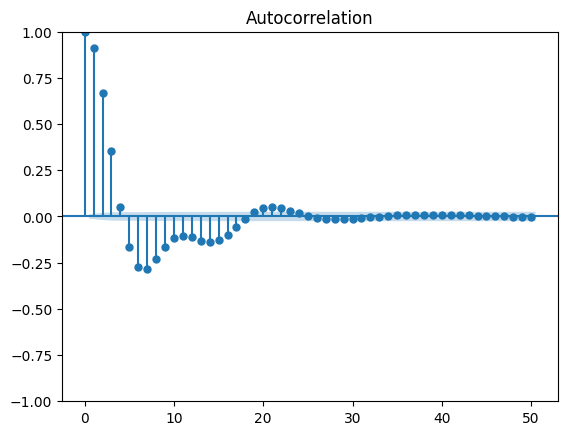

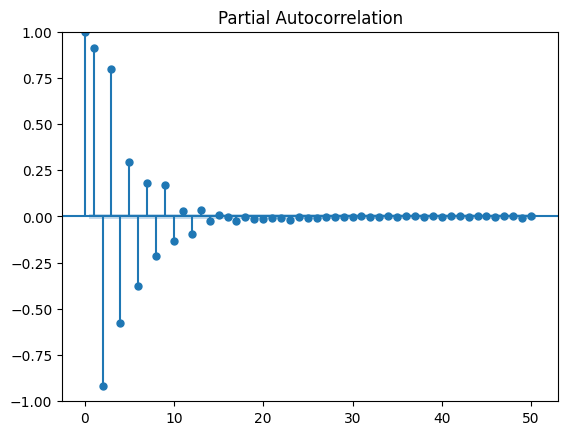

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuals, lags=50)
plt.show()
plot_pacf(residuals, lags=50)
plt.show()

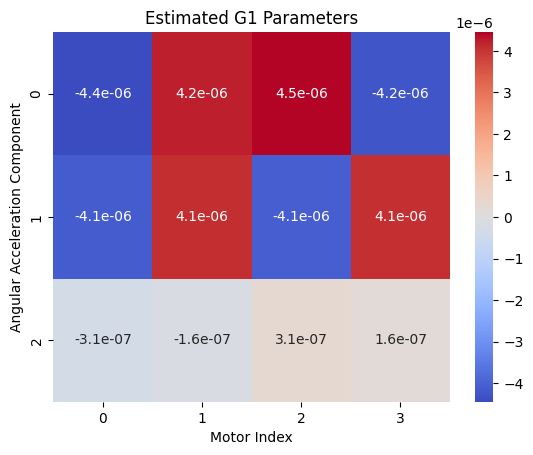

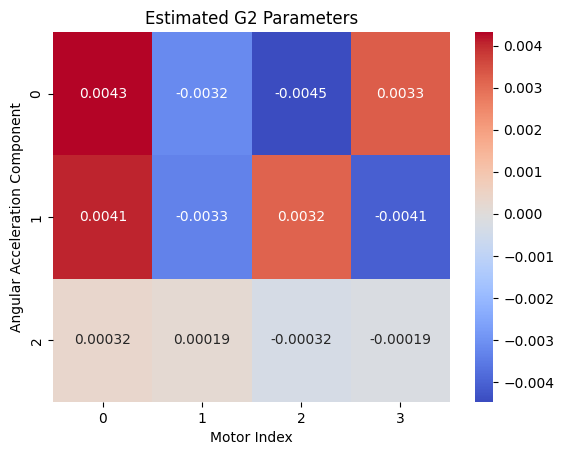

In [9]:
# Heatmap of G1 parameters
sns.heatmap(G1_hat, annot=True, cmap="coolwarm")
plt.title("Estimated G1 Parameters")
plt.xlabel("Motor Index")
plt.ylabel("Angular Acceleration Component")
plt.show()

# Heatmap of G2 parameters
sns.heatmap(G2_hat, annot=True, cmap="coolwarm")
plt.title("Estimated G2 Parameters")
plt.xlabel("Motor Index")
plt.ylabel("Angular Acceleration Component")
plt.show()

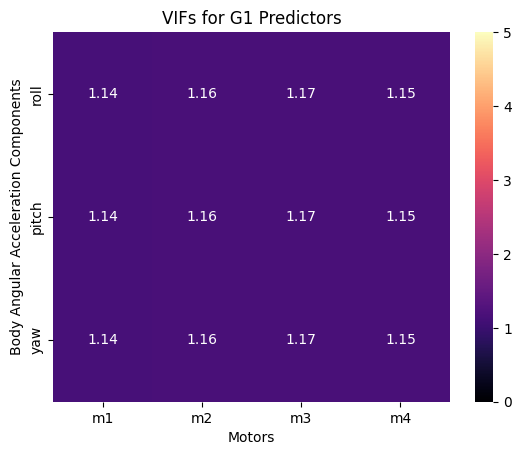

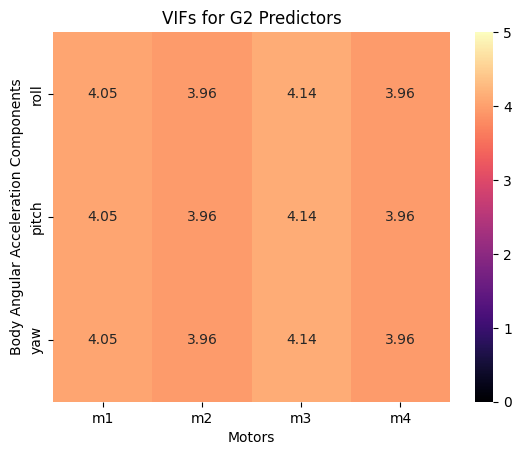

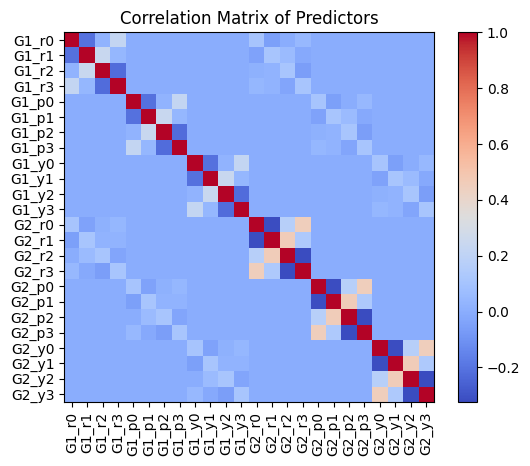

In [10]:
# Check for Multicollinearity

predictor_names = [f"G1_{comp}{i}" for comp in ["r", "p", "y"] for i in range(4)] + [
    f"G2_{comp}{i}" for comp in ["r", "p", "y"] for i in range(4)
]

# Convert X_design to a Polars DataFrame
X_df = pl.DataFrame(X_design, schema=predictor_names)


def compute_vif(X):
    # Calculate the correlation matrix
    corr_matrix = X.corr().to_numpy()
    # Compute the inverse of the correlation matrix
    corr_matrix_inv = np.linalg.inv(corr_matrix)
    # Extract the diagonal elements
    vif_values = np.diag(corr_matrix_inv)
    return vif_values


# Compute VIFs
X_numeric = X_df.to_numpy()
vif_values = compute_vif(pl.DataFrame(X_numeric))
VIFs_G1 = vif_values[:12]
VIFs_G1_matrix = VIFs_G1.reshape(3, 4)  # Shape: (3, 4)
VIFs_G2 = vif_values[12:]
VIFs_G2_matrix = VIFs_G2.reshape(3, 4)  # Shape: (3, 4)

sns.heatmap(
    VIFs_G1_matrix,
    annot=True,
    fmt=".2f",
    cmap="magma",
    xticklabels=["m1", "m2", "m3", "m4"],
    yticklabels=["roll", "pitch", "yaw"],
    vmin=0,
    vmax=5,
)
plt.title("VIFs for G1 Predictors")
plt.xlabel("Motors")
plt.ylabel("Body Angular Acceleration Components")
plt.show()

sns.heatmap(
    VIFs_G2_matrix,
    annot=True,
    fmt=".2f",
    cmap="magma",
    xticklabels=["m1", "m2", "m3", "m4"],
    yticklabels=["roll", "pitch", "yaw"],
    vmin=0,
    vmax=5,
)
plt.title("VIFs for G2 Predictors")
plt.xlabel("Motors")
plt.ylabel("Body Angular Acceleration Components")
plt.show()

corr_matrix = X_df.corr().to_numpy()
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(predictor_names)), predictor_names, rotation=90)
plt.yticks(range(len(predictor_names)), predictor_names)
plt.title("Correlation Matrix of Predictors")
plt.show()

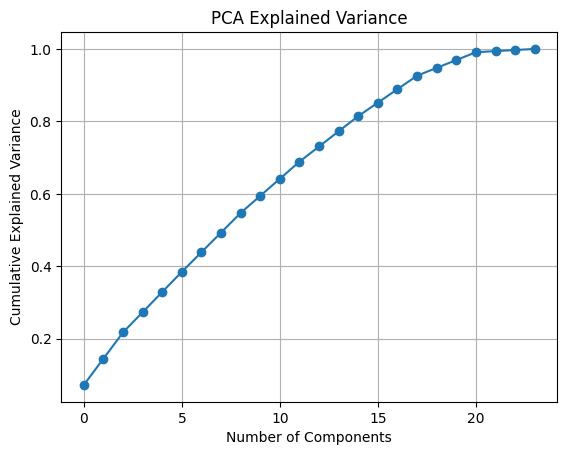

In [11]:
# Principal Component Analysis (PCA)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df.to_numpy())

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.plot(cumulative_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

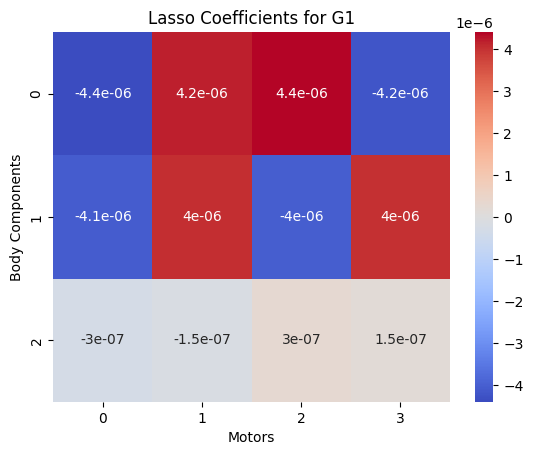

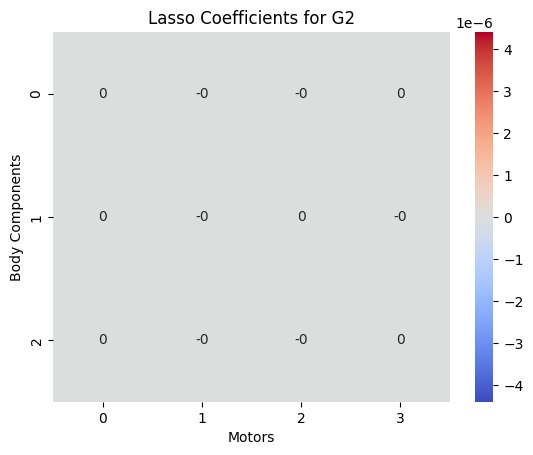

In [12]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5, fit_intercept=False, random_state=42, max_iter=10000)
lasso_cv.fit(X_design, Y_flat)

# Get the coefficients
lasso_coefficients = lasso_cv.coef_  # Shape: (24,)

# Create a list of predictor names
components = ["X", "Y", "Z"]
predictor_names_G1 = [f"G1_{comp}{i}" for comp in components for i in range(4)]
predictor_names_G2 = [f"G2_{comp}{i}" for comp in components for i in range(4)]
predictor_names = predictor_names_G1 + predictor_names_G2  # Total of 24 predictors

# Split coefficients into G1 and G2
coefficients_G1 = lasso_coefficients[:12]  # First 12 coefficients
coefficients_G2 = lasso_coefficients[12:]  # Last 12 coefficients
# Reshape coefficients into (3, 4) matrices for heatmaps
coefficients_G1_matrix = coefficients_G1.reshape(3, 4)  # Shape: (3, 4)
coefficients_G2_matrix = coefficients_G2.reshape(3, 4)  # Shape: (3, 4)
coef_min = np.min(lasso_coefficients)
coef_max = np.max(lasso_coefficients)

sns.heatmap(coefficients_G1_matrix, annot=True, cmap="coolwarm", vmin=coef_min, vmax=coef_max)
plt.title("Lasso Coefficients for G1")
plt.xlabel("Motors")
plt.ylabel("Body Components")
plt.show()

sns.heatmap(coefficients_G2_matrix, annot=True, cmap="coolwarm", vmin=coef_min, vmax=coef_max)
plt.title("Lasso Coefficients for G2")
plt.xlabel("Motors")
plt.ylabel("Body Components")
plt.show()